# setup

In [ ]:
import pandas as pd

csv_urls = {
    'members': 'https://dataspace.princeton.edu/bitstream/88435/dsp01b5644v608/2/SCoData_members_v1.1_2021-01.csv',
    'books': 'https://dataspace.princeton.edu/bitstream/88435/dsp016d570067j/2/SCoData_books_v1.1_2021-01.csv',
    'events': 'https://dataspace.princeton.edu/bitstream/88435/dsp012n49t475g/2/SCoData_events_v1.1_2021-01.csv'

}

# load members, books, events as csv
members_df = pd.read_csv(csv_urls['members'])
books_df = pd.read_csv(csv_urls['books'])
events_df = pd.read_csv(csv_urls['events'])


## limit to events with complete start and end dates

In [ ]:
# subset data for only those with complete start and end dates
date_events = events_df[(events_df.start_date.str.len() > 9) & (events_df.end_date.str.len() > 9)].copy()
# turn start/end dates into datetimes
date_events['start_datetime'] = pd.to_datetime(date_events.start_date, format='%Y-%m-%d', errors='ignore')
date_events['end_datetime'] = pd.to_datetime(date_events.end_date, format='%Y-%m-%d', errors='ignore')
date_events = date_events.sort_values(by=['start_datetime'])
date_events.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime
0,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,1.0,AdL,1919-11-17,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-17,1920-11-17
7995,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,1.0,NaN,1919-11-17,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Lending Library Card;Logbook,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,1919-11-17,1919-12-17
1,Subscription,1919-11-17,1920-02-17,https://shakespeareandco.princeton.edu/members...,Mrs. Worthing,"Worthing, Mrs.",12.0,NaN,3 months,92.0,1.0,NaN,1919-11-17,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-17,1920-02-17
2,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,M. Keller,"Keller, M.",5.0,7.0,1 month,30.0,1.0,NaN,1919-11-18,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-18,1919-12-18
7999,Borrow,1919-11-18,1919-11-28,https://shakespeareandco.princeton.edu/members...,Denise Ulmann,"Ulmann, Denise",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,10.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/m...,Diana of the Crossways,NaN,"Meredith, George",1885.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Denise Ulmann Lending Libra...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/86...,1919-11-18,1919-11-28


In [ ]:
earliest_date = date_events.start_datetime.iloc[0]
earliest_date

Timestamp('1919-11-17 00:00:00')

## separate out borrow events and subscription events

In [ ]:
# borrow events 
borrow_events = date_events[date_events.event_type == 'Borrow']

In [ ]:
# subset data for subscription events with complete dates
subscription_events = date_events[date_events.event_type.isin(['Subscription', 'Renewal', 'Supplement'])]
subscription_events.head()

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime
0,Subscription,1919-11-17,1920-11-17,https://shakespeareandco.princeton.edu/members...,Marcelle Flot,"Flot, Marcelle",28.0,NaN,1 year,366.0,1.0,AdL,1919-11-17,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-17,1920-11-17
7995,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,1.0,NaN,1919-11-17,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Lending Library Card;Logbook,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,1919-11-17,1919-12-17
1,Subscription,1919-11-17,1920-02-17,https://shakespeareandco.princeton.edu/members...,Mrs. Worthing,"Worthing, Mrs.",12.0,NaN,3 months,92.0,1.0,NaN,1919-11-17,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-17,1920-02-17
2,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,M. Keller,"Keller, M.",5.0,7.0,1 month,30.0,1.0,NaN,1919-11-18,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-18,1919-12-18
7996,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",4.0,5.6,1 month,30.0,1.0,Student,1919-11-18,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook;Lending Library Card,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/c...,1919-11-18,1919-12-18


In [ ]:
# end date for the last subscription
subs_end_date = subscription_events.end_datetime.max()
subs_end_date

Timestamp('1942-09-03 00:00:00')

In [ ]:
day = subscription_events.start_datetime.iloc[0]
print(day)
subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum()

1919-11-17 00:00:00


3.0

In [ ]:
subs_vol_totals = subscription_events.groupby(["subscription_volumes"]).size().reset_index(name='count').sort_values(['count'], ascending=False)
# alternately, can be generated more simply via
# subscription_events.subscription_volumes.value_counts()
subs_vol_totals

,subscription_volumes,count
0,1.0,6040
1,2.0,2521
2,3.0,58
3,4.0,31
4,5.0,2
5,6.0,2
6,7.0,2
7,8.0,1
8,10.0,1
9,17.0,1


In [ ]:
subscription_events[subscription_events.subscription_volumes > 4]

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime
220,Subscription,1920-11-13,1920-12-13,https://shakespeareandco.princeton.edu/members...,Mrs. Pierce Williams,"Williams, Mrs. Pierce",18.0,NaN,1 month,30.0,5.0,NaN,1920-11-13,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1920-11-13,1920-12-13
10531,Supplement,1923-12-28,1924-03-27,https://shakespeareandco.princeton.edu/members...,Mme Lowenfeld,"Lowenfeld, Mme",20.0,NaN,"2 months, 28 days",90.0,5.0,NaN,1923-12-28,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1923-12-28,1924-03-27
10875,Renewal,1924-05-01,1924-06-01,https://shakespeareandco.princeton.edu/members...,Colonel Thackeray,"Thackeray, Colonel",48.0,NaN,1 month,31.0,6.0,NaN,1924-05-01,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1924-05-01,1924-06-01
1948,Renewal,1924-06-10,1924-07-10,https://shakespeareandco.princeton.edu/members...,M. Lowenfeld,"Lowenfeld, M.",48.0,NaN,1 month,30.0,6.0,NaN,1924-06-10,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1924-06-10,1924-07-10
3666,Renewal,1926-11-06,1926-11-20,https://shakespeareandco.princeton.edu/members...,Mrs. Kelley,"Kelley, Mrs.",NaN,NaN,2 weeks,14.0,17.0,NaN,1926-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1926-11-06,1926-11-20
13533,Renewal,1926-11-10,1926-11-20,https://shakespeareandco.princeton.edu/members...,R. H. Myers,"Myers, R. H.",NaN,NaN,10 days,10.0,8.0,NaN,1926-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1926-11-10,1926-11-20
3673,Renewal,1926-11-10,1927-11-10,https://shakespeareandco.princeton.edu/members...,Mme Genevoix,"Genevoix, Mme",NaN,NaN,1 year,365.0,60.0,NaN,1926-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1926-11-10,1927-11-10
18944,Subscription,1932-11-10,1933-02-10,https://shakespeareandco.princeton.edu/members...,Sarah Pressly Watson / Miss S. P. Watson,"Watson, Sarah Pressly",65.0,NaN,3 months,92.0,10.0,NaN,1932-11-10,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook;Lending Library Card,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/5...,1932-11-10,1933-02-10
27657,Subscription,1938-03-02,1938-04-02,https://shakespeareandco.princeton.edu/members...,Ford Madox Ford,"Ford, Ford Madox",30.0,20.0,1 month,31.0,7.0,NaN,1938-03-02,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Lending Library Card,"Sylvia Beach, Ford Madox Ford Lending Library ...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/b9...,1938-03-02,1938-04-02
33702,Subscription,1941-05-27,1942-05-27,https://shakespeareandco.princeton.edu/members...,Mme Jean Seillière,"Seillière, Mme Jean",300.0,NaN,1 year,365.0,7.0,NaN,1941-05-27,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook;Lending Library Card,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/4...,1941-05-27,1942-05-27


## report on number of events excluded

In [ ]:
# subset data for only those with complete start and end dates
# - completely missing
no_dates = events_df[events_df.start_date.isna() & events_df.end_date.isna()]
no_start = events_df[events_df.start_date.isna() & events_df.end_date.notna()]
no_end = events_df[events_df.start_date.notna() & events_df.end_date.isna()]

# - partially missing
partial_dates = events_df[(events_df.start_date.str.len() < 10) & (events_df.end_date.str.len() < 10)]
partial_start = events_df[(events_df.start_date.str.len() < 10) & (events_df.end_date.str.len() >= 10)]
partial_end = events_df[(events_df.start_date.str.len() >= 10) & (events_df.end_date.str.len() < 10)]

excluded_events = pd.DataFrame([
  ['no_dates', len(no_dates)],
  ['no_start', len(no_start)],
  ['no_end', len(no_end)],
  ['partial_dates', len(partial_dates)],
  ['partial_start', len(partial_start)],
  ['partial_end', len(partial_end)]
], columns=["label", "count"])
print('Excluded events, any type')
excluded_events

Excluded events, any type


,label,count
0,no_dates,100
1,no_start,74
2,no_end,2092
3,partial_dates,179
4,partial_start,101
5,partial_end,132


### excluded borrow events

In [ ]:
# report on excluded events for borrows
excluded_borrows = pd.DataFrame([
  ['no_dates', len(no_dates[no_dates.event_type == 'Borrow'])],
  ['no_start', len(no_start[no_start.event_type == 'Borrow'])],
  ['no_end', len(no_end[no_end.event_type == 'Borrow'])],
  ['partial_dates', len(partial_dates[partial_dates.event_type == 'Borrow'])],
  ['partial_start', len(partial_start[partial_start.event_type == 'Borrow'])],
  ['partial_end', len(partial_end[partial_end.event_type == 'Borrow'])]
], columns=["label", "count"])
print('Excluded borrows')
excluded_borrows


Excluded borrows


,label,count
0,no_dates,7
1,no_start,74
2,no_end,916
3,partial_dates,62
4,partial_start,100
5,partial_end,131


### excluded subscription events

In [ ]:
# report on excluded events for subscriptions 
excluded_subscriptions = pd.DataFrame([
  ['no_dates', len(no_dates[no_dates.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['no_start', len(no_start[no_start.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['no_end', len(no_end[no_end.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['partial_dates', len(partial_dates[partial_dates.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['partial_start', len(partial_start[partial_start.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])],
  ['partial_end', len(partial_end[partial_end.event_type.isin(['Subscription', 'Renewal', 'Supplement'])])]
], columns=["label", "count"])
print('Excluded subscriptions')
excluded_subscriptions

Excluded subscriptions


,label,count
0,no_dates,6
1,no_start,0
2,no_end,636
3,partial_dates,96
4,partial_start,0
5,partial_end,1


# calculate borrowing capacity

## generated filtered subscription set for members with cards

Members with extant cards won't filter exactly as needed, since we know there are some members with partial borrowing history, but should a useful first look at borrowing capacity

In [ ]:
member_subs = subscription_events.copy()
member_subs[['first_member_uri','second_member_uri']] = member_subs.member_uris.str.split(';', expand=True)
# handle multiple member uris (joint accounts) in subscriptions by merging on the first one (has card should be same)
member_subs = pd.merge(left=member_subs, right=members_df, left_on="first_member_uri", right_on="uri")
member_subs = member_subs[member_subs.has_card]
member_subs


,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime,first_member_uri,second_member_uri,uri,name,sort_name,title,gender,is_organization,has_card,birth_year,death_year,membership_years,viaf_url,wikipedia_url,nationalities,addresses,postal_codes,arrondissements,coordinates,notes,updated
1,Subscription,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",4.0,NaN,1 month,30.0,1.0,NaN,1919-11-17,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Lending Library Card;Logbook,"Sylvia Beach, Lucie Schwob Lending Library Car...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/3a...,1919-11-17,1919-12-17,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Claude Cahun / Mlle Lucie Schwob,"Cahun, Claude",NaN,Nonbinary,False,True,1894.0,1954.0,1919,http://viaf.org/viaf/19757660,http://en.wikipedia.org/wiki/Claude_Cahun,France,"Hôtel Saint Thomas D'Aquin, 3 rue du Pré aux C...",75007,7,"48.85654, 2.33035",NaN,2020-01-03T00:13:26+00:00
15,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",4.0,5.6,1 month,30.0,1.0,Student,1919-11-18,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook;Lending Library Card,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/c...,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Henri Regnier,"Regnier, Henri",M.,Male,False,True,NaN,NaN,1919,NaN,NaN,NaN,"9 rue de la Gare, Cachan",94230,NaN,"48.79898, 2.32760",NaN,2019-12-31T05:00:10+00:00
16,Subscription,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,Denise Ulmann,"Ulmann, Denise",6.4,11.2,1 month,30.0,2.0,Student,1919-11-18,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook;Lending Library Card,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/8...,1919-11-18,1919-12-18,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Denise Ulmann,"Ulmann, Denise",Mlle,Female,False,True,1902.0,1994.0,1919,NaN,NaN,France,"28 place Saint-Ferdinand, Paris",75017,17,"48.87824, 2.28831",NaN,2019-12-31T01:29:35+00:00
18,Subscription,1919-11-19,1920-05-19,https://shakespeareandco.princeton.edu/members...,Maurice Oerthel,"Oerthel, Maurice",16.0,NaN,6 months,182.0,1.0,AdL,1919-11-19,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook;Lending Library Card,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/a...,1919-11-19,1920-05-19,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Maurice Oerthel,"Oerthel, Maurice",M.,Male,False,True,NaN,NaN,1920;1921;1919,NaN,NaN,NaN,"36 rue Saint-André des Arts, Paris",75006,6,"48.85344, 2.34170",NaN,2020-01-03T02:32:32+00:00
19,Renewal,1920-05-19,1920-11-19,https://shakespeareandco.princeton.edu/members...,Maurice Oerthel,"Oerthel, Maurice",16.0,NaN,6 months,184.0,1.0,AdL,1920-05-31,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook;Lending Library Card,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",;https://figgy.princeton.edu/concern/scanned_r...,;https://iiif.princeton.edu/loris/figgy_prod/2...,1920-05-19,1920-11-19,htt

## calculate total books out and subscription volumes per day

In [ ]:
from datetime import date, timedelta
# arbritrary end date while testing
#end_day = date(1925, 6, 1)
# go through end of last subscription end date
#end_day = subs_end_date
one_day = timedelta(days=1)
# start with the earliest start date
day = date_events.start_datetime.iloc[0]

dates = []
books_out = []
subscription_vols = []
card_subscription_vols = []

while day < subs_end_date:
    dates.append(day)
    # get total number of borrowing events spanning this date; include start date, exclude end (to avoid double counting)
    books_out.append(len(borrow_events[(borrow_events.start_datetime <= day) & (borrow_events.end_datetime > day)]))
    # total number of volumes from active subscriptions for this date
    subscription_vols.append(subscription_events[(subscription_events.start_datetime <= day) & (day < subscription_events.end_datetime)].subscription_volumes.sum())
    # total number of volumes from subscriptions for members with extant cards
    card_subscription_vols.append(member_subs[(member_subs.start_datetime <= day) & (day < member_subs.end_datetime)].subscription_volumes.sum())

    day += one_day

borrowing_df  = pd.DataFrame()
borrowing_df['date'] = dates
borrowing_df['books_out'] = books_out
borrowing_df['subscription_volumes'] = subscription_vols
borrowing_df['card_subscription_volumes'] = card_subscription_vols
borrowing_df

,date,books_out,subscription_volumes,card_subscription_volumes
0,1919-11-17,0,3.0,1.0
1,1919-11-18,3,9.0,4.0
2,1919-11-19,5,10.0,5.0
3,1919-11-20,5,11.0,5.0
4,1919-11-21,5,13.0,5.0
...,...,...,...,...
8321,1942-08-29,17,1.0,1.0
8322,1942-08-30,17,1.0,1.0
8323,1942-08-31,17,1.0,1.0
8324,1942-09-01,17,1.0,1.0


### chart: daily books out vs total subscription volumes

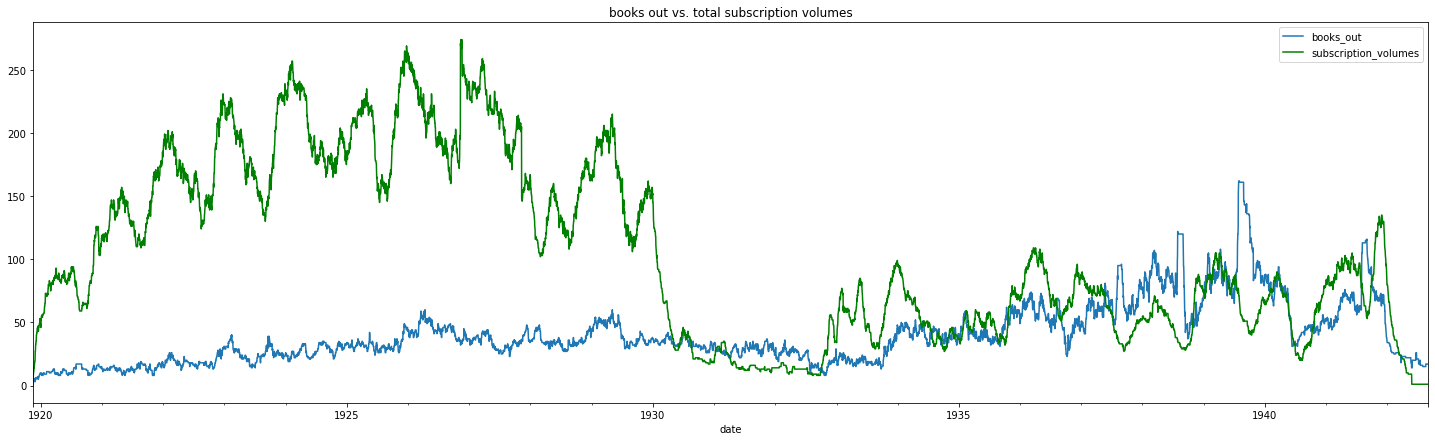

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# get current axis so we can plot two series on the same axis
ax = plt.gca()

borrowing_df.plot(kind='line',x='date',y='books_out',ax=ax, figsize=(25,7), title='books out vs. total subscription volumes')
borrowing_df.plot(kind='line',x='date',y='subscription_volumes', color='green', ax=ax)

plt.savefig('sco_borrowing_capacity.png')
plt.show()


### chart: daily books out vs subscription volumes for members with extant card

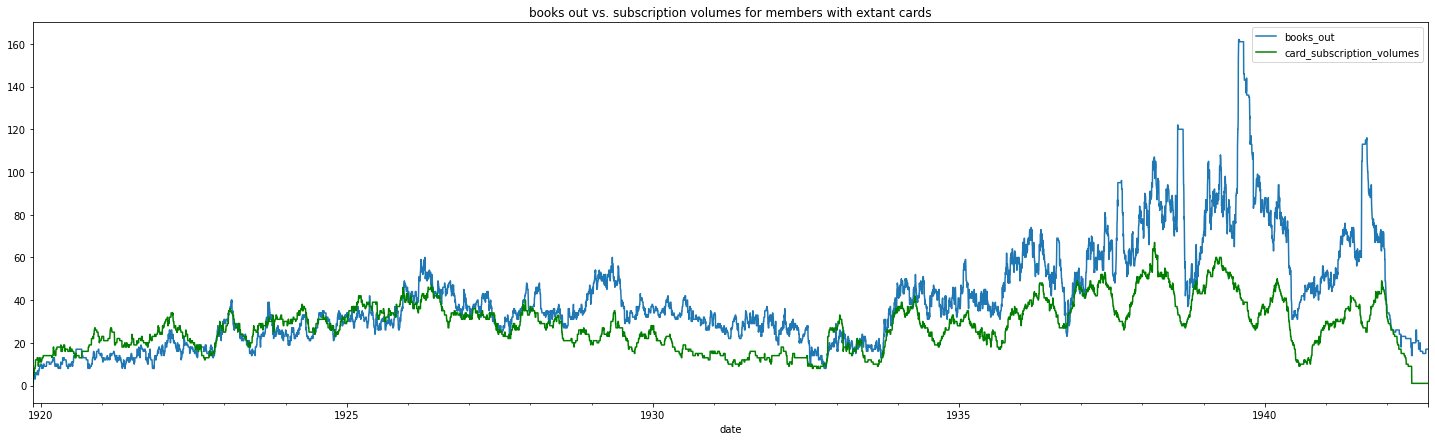

In [ ]:
# same plot but limited to members with extant cards (any time, includes partial cards)
ax = plt.gca()
borrowing_df.plot(kind='line',x='date',y='books_out',ax=ax, figsize=(25,7),
                  title='books out vs. subscription volumes for members with extant cards')
borrowing_df.plot(kind='line',x='date',y='card_subscription_volumes', color='green', ax=ax)
plt.show()


Based on this plot, we have a lot of borrowing going on beyond what the subscriptions indicate should have been allowed. Lots of friends and family borrowing? Overdue books that weren't counted against volume limits?

## percent of available subscription volumes used (members with extant cards)

In [ ]:
# calculate what percent of available subscription volumes was used (members with cards only)
borrowing_df['pct_used'] = borrowing_df.apply(lambda x: x.books_out / x.card_subscription_volumes, axis=1)
borrowing_df

,date,books_out,subscription_volumes,card_subscription_volumes,pct_used
0,1919-11-17,0,3.0,1.0,0.00
1,1919-11-18,3,9.0,4.0,0.75
2,1919-11-19,5,10.0,5.0,1.00
3,1919-11-20,5,11.0,5.0,1.00
4,1919-11-21,5,13.0,5.0,1.00
...,...,...,...,...,...
8321,1942-08-29,17,1.0,1.0,17.00
8322,1942-08-30,17,1.0,1.0,17.00
8323,1942-08-31,17,1.0,1.0,17.00
8324,1942-09-01,17,1.0,1.0,17.00


In [ ]:
borrowing_df.pct_used.agg(['min', 'max', 'mean'])

min      0.000000
max     26.000000
mean     1.672456
Name: pct_used, dtype: float64

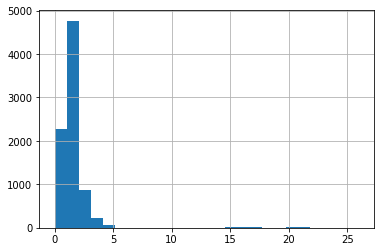

In [ ]:
borrowing_df.pct_used.hist(bins=25)

# limit to borrows and subscriptions that overlap

To calculate better based on partial borrowing records and borrowing without subscriptions, only consider subscriptions with at least one borrow and borrows that overlap with at least one subscription.

## identify borrows within subscriptions

In [ ]:
# identify borrows that occur with/without active subscriptions
# for each borrow event, check if there is a subscription event for the same first member uri 
# with any overlap in dates

# make a copy of the dataframe so pandas won't complain about setting values on a slice
borrow_events_df = borrow_events.copy()
# split out multiple member uris to match on member_subs df
borrow_events_df[['first_member_uri','second_member_uri']] = borrow_events_df.member_uris.str.split(';', expand=True)

def borrow_within_sub(borrow):
  return len(member_subs[(member_subs.first_member_uri == borrow.first_member_uri) & 
              (member_subs.start_date <= borrow.end_date) &
              (member_subs.end_date >= borrow.start_date)])

borrow_events_df['within_subscription'] = borrow_events_df.apply(borrow_within_sub, axis=1)
borrow_events_df.within_subscription.value_counts()



1    15568
0     2408
2     1709
3       82
4        3
6        1
Name: within_subscription, dtype: int64

In [ ]:
# inspect results
# borrows without subscription
borrow_events_df[borrow_events_df.within_subscription == 0]

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime,first_member_uri,second_member_uri,within_subscription
8075,Borrow,1920-01-12,1920-01-22,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,10.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/g...,"Addresses in America, 1919",NaN,"Galsworthy, John",1919.0,NaN,Lending Library Card,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,1920-01-12,1920-01-22,https://shakespeareandco.princeton.edu/members...,None,0
8084,Borrow,1920-01-22,1920-03-13,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,51.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/d...,Sister Carrie,NaN,"Dreiser, Theodore",1900.0,NaN,Lending Library Card,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,1920-01-22,1920-03-13,https://shakespeareandco.princeton.edu/members...,None,0
8131,Borrow,1920-03-13,1920-04-17,https://shakespeareandco.princeton.edu/members...,Blanche Reverchon,"Reverchon, Blanche",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,35.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/h...,The Return of the Native,NaN,"Hardy, Thomas",1878.0,NaN,Lending Library Card,"Sylvia Beach, Blanche Reverchon Lending Librar...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/7e...,1920-03-13,1920-04-17,https://shakespeareandco.princeton.edu/members...,None,0
8164,Borrow,1920-04-13,1920-04-19,https://shakespeareandco.princeton.edu/members...,André Maurois,"Maurois, André",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,6.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/d...,The Autobiography of a Super-Tramp,NaN,"Davies, W. H.",1908.0,NaN,Lending Library Card,"Sylvia Beach, André Maurois Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/65...,1920-04-13,1920-04-19,https://shakespeareandco.princeton.edu/members...,None,0
8165,Borrow,1920-04-13,1921-04-22,https://shakespeareandco.princeton.edu/members...,André Maurois,"Maurois, André",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,374.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/f...,Totem and Taboo,NaN,"Freud, Sigmund",1919.0,NaN,Lending Library Card,"Sylvia Beach, André Maurois Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/65...,1920-04-13,1921-04-22,https://shakespeareandco.princeton.edu/members...,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35019,Borrow,1961-06-30,1961-10-04,https://shakespeareandco.princeton.edu/members...,Henri Michaux,"Michaux, Henri",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,96.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/d...,Thomas De Quincey's Works,NaN,"de Quincey, Thomas",NaN,Partial identification. At least two sets of D...,Lending Library Card,"Sylvia Beach, Henri Michaux Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/5b...,1961-06-30,1961-10-04,https://shakespeareandco.princeton.edu/members...,None,0
35020,Borrow,1961-06-30,1961-10-04,https://shakespeareandco.princeton.edu/members...,Henri Michaux,"M

In [ ]:
borrow_events_df[borrow_events_df.within_subscription == 0].member_names.value_counts()

Mlle Ottocar                                                        104
François Valéry                                                     101
Bravig Imbs                                                          76
Dorothy Plummer                                                      73
Jeanne Fournier                                                      73
                                                                   ... 
Maurice Saur                                                          1
Elisabeth de Roos / Mrs. du Perron;E. du Perron / Eddy du Perron      1
Mary Sophie Ludlow                                                    1
Horatio Robert Swasey                                                 1
David Ponsonby                                                        1
Name: member_names, Length: 235, dtype: int64

preliminary inspection of borrows occurring outside of subscriptions 

- Blanch Reverchon: subs Dec 1919 - Jan 1920, but borrows continue into March and April
- André Maurois: 3month sub Dec 1919 - March 1920; borrowing continues into March and April
- Henri Michaux: no documented subscriptions; borrow events 1944; 1950 – 1951; 1955; 1961 (all after bookshop officiall closed)
- Mlle Ottocar: subs 1921-1927, partial in 1929; borrow events 1920-1931
- François Valéry: no documented subscriptions; most likely Beach let him borrow without one
- Jeanne Fournier: subs 1925-1930; borrows 1925-1931 (likely missing subs due to missing 1930s logbooks)
- Bravig Imbs: subs 1925, 1928; borrows 1927-1931
- Dorothy Plummer: only one 1m sub in 1936; borrow events 1931-1937


In [ ]:
# borrows overlapping with multiple subscriptions
borrow_events_df[borrow_events_df.within_subscription > 2]

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime,first_member_uri,second_member_uri,within_subscription
8367,Borrow,1920-11-13,1920-11-25,https://shakespeareandco.princeton.edu/members...,Mme L. Michaelides,"Michaelides, Mme L.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,12.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/a...,Collected Poems,NaN,Æ,1920.0,NaN,Lending Library Card,"Sylvia Beach, Madame L. Michaelides Lending Li...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/94...,1920-11-13,1920-11-25,https://shakespeareandco.princeton.edu/members...,None,3
8412,Borrow,1920-12-04,1920-12-09,https://shakespeareandco.princeton.edu/members...,Mlle Tournier,"Tournier, Mlle",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,5.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/b...,The Human Machine,NaN,"Bennett, Arnold",1908.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Tournier Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/bd...,1920-12-04,1920-12-09,https://shakespeareandco.princeton.edu/members...,None,3
8413,Borrow,1920-12-04,1920-12-09,https://shakespeareandco.princeton.edu/members...,Mlle Tournier,"Tournier, Mlle",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,5.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/j...,The Idle Thoughts of an Idle Fellow,NaN,"Jerome, Jerome K.",1886.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Tournier Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/bd...,1920-12-04,1920-12-09,https://shakespeareandco.princeton.edu/members...,None,3
8416,Borrow,1920-12-09,1920-12-13,https://shakespeareandco.princeton.edu/members...,Mlle Tournier,"Tournier, Mlle",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,4.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/m...,The Spirit of American Literature,NaN,"Macy, John Albert",1913.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Tournier Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/bd...,1920-12-09,1920-12-13,https://shakespeareandco.princeton.edu/members...,None,3
8417,Borrow,1920-12-09,1920-12-13,https://shakespeareandco.princeton.edu/members...,Mlle Tournier,"Tournier, Mlle",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,4.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/t...,A History of American Literature,NaN,"Trent, William P.",1903.0,NaN,Lending Library Card,"Sylvia Beach, Mlle Tournier Lending Library Ca...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/bd...,1920-12-09,1920-12-13,https://shakespeareandco.princeton.edu/members...,None,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33340,Borrow,1941-03-18,1941-05-15,https://shakespeareandco.princeton.edu/members...,Bianca (Bienenfeld) Lamblin / Mlle Bianca Bien...,"Lamblin, Bianca",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Returned,58.0,NaN,NaN,https://shakespeareandco.princeton.edu/books/h...,Death in the Afternoon,NaN,"Hemingway, Ernest",1932.0,NaN,Lending Library Card,"Sylvia Beach, Bianca Bienenfeld Lamblin Lendin...",https://figgy.princeton.edu/concern/scanned_re...,https://iiif.princeton.edu/loris/figgy_prod/c5...,1941-03-18,1941-05-15,https://shakespeareandco.princeton.edu/members...,None,3
33343,Borrow,1941-03-18,1941-03-24,https://shakespeareandco.princeton.edu/members...,Mrs. Emory Whitridge,"Whitridge, M

In [ ]:
borrow_events_df[borrow_events_df.within_subscription > 2].member_names.value_counts()

Leo Stein                                                     11
Stanislas Pascal Franchot                                      6
Mrs. Jackson                                                   4
Eda Lord                                                       4
Mlle Tournier                                                  4
Raymonde Lamirault                                             4
Renée Antoine-May                                              4
Anatole Rivoallan                                              3
Mrs. Thornton Baker                                            3
Mme Schueller                                                  2
Mlle Valerio                                                   2
Adelaide W. Massey / A. W. Massey                              2
Henri Maspero;Hélène Maspero-Clerc                             2
E. M. Churchill                                                2
Madeleine Rolland                                              2
Mlle Ottocar             

preliminary inspection of borrows occurring overlapping with > 2 subscriptions 

Would expect to see this for borrows that start under one subscription and end in another AND for members who purchased a supplement

- Leo Stein: supplement apr 8 - may 8 1924; 3 books borrowed May 7 would overlap with march 2 renewal, apr 8 supplement, may 18 renewal? (possible data error here: 2m 15 day renewal may 13-jul 28 overlaps with june 2 renewal)
- Franchot: 2 overlapping supplements

Some of these have odd-looking subscriptions, could be data errors in subscription dates (Eda Lord, Rivoallan), but calculation seems to be reasonable based on the data we have now

## annotate subscriptions with borrow count

In [ ]:
# identify subscriptions with at least one overlapping borrow
# for each subscription event, count the number of borrow events for the same first member uri with any overlap in start/end dates

# make a copy of the dataframe so pandas won't complain about setting values on a slice
member_subs_df = member_subs.copy()

def borrows_within_sub(sub):
  return len(borrow_events_df[
        (borrow_events_df.first_member_uri == sub.first_member_uri) &
        (borrow_events_df.start_date <= sub.end_date) &
        (borrow_events_df.end_date >= sub.start_date)])


member_subs_df['borrow_count'] = member_subs_df.apply(borrows_within_sub, axis=1)
member_subs_df.borrow_count.value_counts()

0      232
3      156
4      147
5      136
6      120
      ... 
68       1
61       1
57       1
54       1
159      1
Name: borrow_count, Length: 85, dtype: int64

In [ ]:
# subscriptions with no borrows
member_subs_df[member_subs_df.borrow_count == 0]

,event_type,start_date,end_date,member_uris,member_names,member_sort_names,subscription_price_paid,subscription_deposit,subscription_duration,subscription_duration_days,subscription_volumes,subscription_category,subscription_purchase_date,reimbursement_refund,borrow_status,borrow_duration_days,purchase_price,currency,item_uri,item_title,item_volume,item_authors,item_year,item_notes,source_type,source_citation,source_manifest,source_image,start_datetime,end_datetime,first_member_uri,second_member_uri,uri,name,sort_name,title,gender,is_organization,has_card,birth_year,death_year,membership_years,viaf_url,wikipedia_url,nationalities,addresses,postal_codes,arrondissements,coordinates,notes,updated,borrow_count
26,Subscription,1919-11-22,1920-11-22,https://shakespeareandco.princeton.edu/members...,Marie Boscq / Bosq,"Boscq, Marie",28.0,7.0,1 year,366.0,1.0,NaN,1919-11-22,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-22,1920-11-22,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Marie Boscq / Bosq,"Boscq, Marie",Mlle,Female,False,True,NaN,NaN,1920;1921;1922;1932;1933;1934;1939;1940;1941;1...,NaN,NaN,NaN,"2 rue Crébillon, Paris",75006,6,"48.85025, 2.33820",NaN,2021-01-06T21:44:22+00:00,0
27,Subscription,1920-12-31,1921-06-30,https://shakespeareandco.princeton.edu/members...,Marie Boscq / Bosq,"Boscq, Marie",28.0,NaN,6 months,181.0,1.0,NaN,1920-12-31,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1920-12-31,1921-06-30,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Marie Boscq / Bosq,"Boscq, Marie",Mlle,Female,False,True,NaN,NaN,1920;1921;1922;1932;1933;1934;1939;1940;1941;1...,NaN,NaN,NaN,"2 rue Crébillon, Paris",75006,6,"48.85025, 2.33820",NaN,2021-01-06T21:44:22+00:00,0
28,Renewal,1921-08-25,1922-02-25,https://shakespeareandco.princeton.edu/members...,Marie Boscq / Bosq,"Boscq, Marie",35.0,NaN,6 months,184.0,1.0,NaN,1921-08-25,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1921-08-25,1922-02-25,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Marie Boscq / Bosq,"Boscq, Marie",Mlle,Female,False,True,NaN,NaN,1920;1921;1922;1932;1933;1934;1939;1940;1941;1...,NaN,NaN,NaN,"2 rue Crébillon, Paris",75006,6,"48.85025, 2.33820",NaN,2021-01-06T21:44:22+00:00,0
36,Subscription,1919-11-24,1920-05-24,https://shakespeareandco.princeton.edu/members...,Mrs. Bernheim,"Bernheim, Mrs.",16.0,NaN,6 months,182.0,1.0,AdL,1919-11-24,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1919-11-24,1920-05-24,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Mrs. Bernheim,"Bernheim, Mrs.",Mrs.,Female,False,True,NaN,NaN,1920;1921;1922;1923;1924;1925;1926;1927;1928;1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-03T00:56:57+00:00,0
37,Renewal,1921-02-18,1921-05-18,https://shakespeareandco.princeton.edu/members...,Mrs. Bernheim,"Bernheim, Mrs.",16.0,NaN,3 months,89.0,1.0,AdL,1921-02-18,NaN,NaN,NaN,NaN,FRF,NaN,NaN,NaN,NaN,NaN,NaN,Logbook,"Sylvia Beach, Logbooks 1919–1941, Sylvia Beach...",NaN,NaN,1921-02-18,1921-05-18,https://shakespeareandco.princeton.edu/members...,None,https://shakespeareandco.princeton.edu/members...,Mrs. Bernheim,"Bernheim, Mrs.",Mrs.,Female,False,True,NaN,NaN,1920;1921;1922;1923;1924;1925;1926;1927;1928;1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-03T00:56:57+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8473,Subscription,1940-02-02,1940-03-02,https://shakespeareandco.princeton.edu/members...,M

Preliminary inspection of subscriptions with no borrows — calculation looks reasonable

- Marie Boscq: subs in 1920-21 but borrowing not documented until 1932
- Mrs. Berheim: similar: no borrowing records for early subscriptiosn (1920s)
- Mrs. Quennell: 1m sub in 1940; 1 borrow in 1940 with no end date 

## calculate daily books out vs subscription volumes for overlapping borrows/subscriptions

In [ ]:
# repeat the same plot but limited to borrows and subscriptions that overlap

# subscription events with at least one borrow
subs_with_borrows = member_subs_df[member_subs_df.borrow_count != 0] 
# borrows that overlap with a subscription
borrows_within_subs = borrow_events_df[borrow_events_df.within_subscription != 0]

# adapt previous code rerun with the filtered events 
# go through end of last subscription end date
one_day = timedelta(days=1)
# start with the earliest start date
day = date_events.start_datetime.iloc[0]

overlap_dates = []
overlap_books_out = []
overlap_subscription_vols = []

while day < subs_end_date:
     overlap_dates.append(day)
     # get total number of borrowing events (within subscriptions) spanning this date; include start date, exclude end (to avoid double counting)
     overlap_books_out.append(len(borrows_within_subs[(borrows_within_subs.start_datetime <= day) & (borrows_within_subs.end_datetime > day)]))
     # total number of volumes from active subscriptions (with borrows) for this date
     overlap_subscription_vols.append(subs_with_borrows[(subs_with_borrows.start_datetime <= day) & (day < subs_with_borrows.end_datetime)].subscription_volumes.sum())

     day += one_day

overlap_borrowing_df  = pd.DataFrame()
overlap_borrowing_df['date'] = overlap_dates
overlap_borrowing_df['books_out'] = overlap_books_out
overlap_borrowing_df['subscription_volumes'] = overlap_subscription_vols
overlap_borrowing_df

,date,books_out,subscription_volumes
0,1919-11-17,0,1.0
1,1919-11-18,3,4.0
2,1919-11-19,5,5.0
3,1919-11-20,5,5.0
4,1919-11-21,5,5.0
...,...,...,...
8321,1942-08-29,2,1.0
8322,1942-08-30,2,1.0
8323,1942-08-31,2,1.0
8324,1942-09-01,2,1.0


### chart: borrows vs subscription volumes

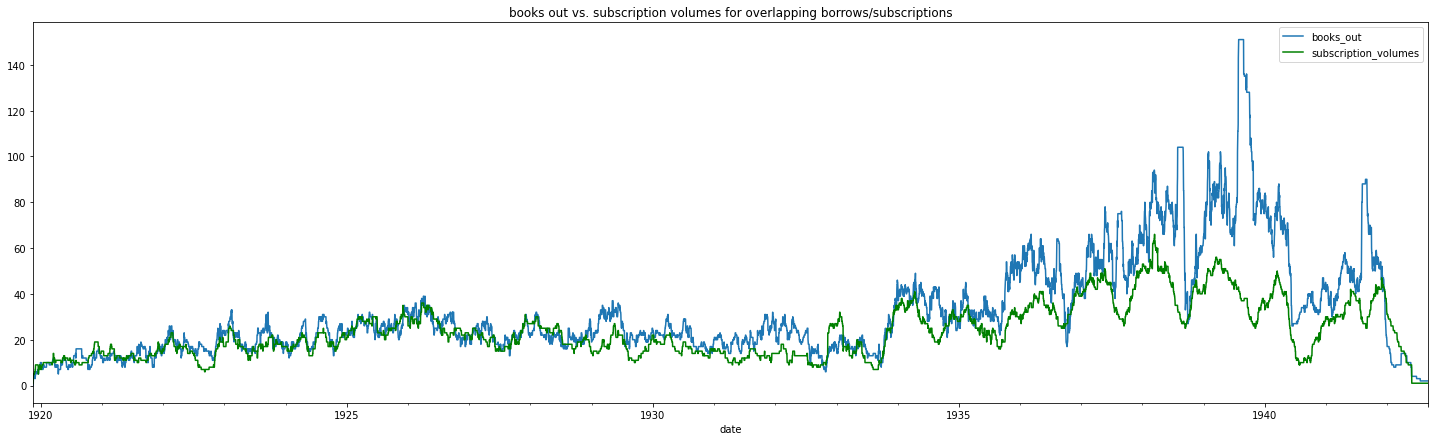

In [ ]:
ax = plt.gca()
overlap_borrowing_df.plot(kind='line',x='date',y='books_out',ax=ax, figsize=(25,7),
                   title='books out vs. subscription volumes for overlapping borrows/subscriptions')
overlap_borrowing_df.plot(kind='line',x='date',y='subscription_volumes', color='green', ax=ax)
plt.show()

In this version of the graph, the books out and subscription volumes track each other much more closely through the early 1930s. Still not sure what is going on after 1935! I thought limiting to overlapping subscriptions and borrows would make this clearer. Are there data errors? Did I not limit things the way I thought? Did Beach get more lax in enforcing subscription limits? Could including long checkouts be skewing the results?




## percent of available subscription volumes used

In [ ]:
# calculate what percent of available subscription volumes was used
overlap_borrowing_df['pct_used'] = overlap_borrowing_df.apply(lambda x: x.books_out / x.subscription_volumes, axis=1)
overlap_borrowing_df

,date,books_out,subscription_volumes,pct_used
0,1919-11-17,0,1.0,0.00
1,1919-11-18,3,4.0,0.75
2,1919-11-19,5,5.0,1.00
3,1919-11-20,5,5.0,1.00
4,1919-11-21,5,5.0,1.00
...,...,...,...,...
8321,1942-08-29,2,1.0,2.00
8322,1942-08-30,2,1.0,2.00
8323,1942-08-31,2,1.0,2.00
8324,1942-09-01,2,1.0,2.00


In [ ]:
overlap_borrowing_df.pct_used.agg(['min', 'max', 'mean'])

min     0.000000
max     4.266667
mean    1.373188
Name: pct_used, dtype: float64

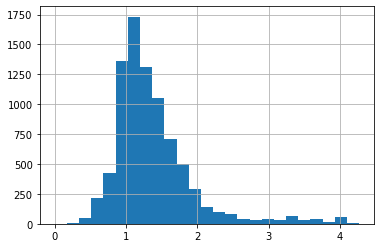

In [ ]:
overlap_borrowing_df.pct_used.hist(bins=25)

# preliminary conclusion

Using the known subscription volumes as a **minimum** for likely book activity seems reasonable. Available evidence suggests there was _more_ borrowing going on than that, at least in the later years.